# ISMN data

Currently running in python 3.9(.11)

requirements:

pip intall ismn  
pip install Cartopy  
pip install matplotlib  
pip install numpy  

Resources:

Download ISMN data from: 
https://ismn.earth/en/

ISMN package documentation:
https://pypi.org/project/ismn/

Cartopy Documentation: 
https://scitools.org.uk/cartopy/docs/latest/

## Known bugs

There seems to be an issue when downloading either air temperature or snow depth data. The versions 1.4.* of ismn will spit out an error
abot date format when generating the metadata 



In [1]:
# Libraries
from ismn.interface import ISMN_Interface
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Global
%matplotlib inline

# Change to the directory where you have the ISMN zip downloaded.
data_path = (
    "../data/raw/Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.zip"
)

In [2]:
import ismn

# I found a bug when generating the metadata if ismn version is not 1.3.0
ismn.__version__ == "1.3.0"

True

In [3]:
# This will take a while the first time, while the interface creates all the indeces.
ismn_data = ISMN_Interface(data_path, parallel=True)

Found existing ismn metadata in ..\data\raw\python_metadata\Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.csv.


In [4]:
ismn_data.get_variables()

array(['soil_moisture', 'soil_temperature', 'surface_temperature'],
      dtype='<U32')

In [5]:
# Hierarchical structure: ismn_data[network][station][sensor]
ismn_data["ARM"]["Anthony"]["STP-1-A_soil_temperature_0.000000_0.050000"].data

# Sensor name codes for variable and depth: _<variable>_<start/ m>_<end/ m>.  https://ismn.earth/en/data/metadata/

c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  readf = lambda f: pd.read_csv(


,soil_temperature,soil_temperature_flag,soil_temperature_orig_flag
date_time,,,
2017-01-02 00:00:00,4.134180,G,M
2017-01-02 01:00:00,4.108790,G,M
2017-01-02 02:00:00,3.985600,G,M
2017-01-02 03:00:00,3.804640,G,M
2017-01-02 04:00:00,3.674370,G,M
...,...,...,...
2017-12-30 20:00:00,-0.637568,G,M
2017-12-30 21:00:00,-0.580889,G,M
2017-12-30 22:00:00,-0.520299,G,M


In [6]:
# Basic Query: select data by index and or metadata:

# Get the ids for the USCRN network and subset from the whole dataset.
ids = ismn_data.get_dataset_ids(
    variable=["surface_temperature", "soil_temperature"],
    filter_meta_dict={"network": "USCRN"},
)
uscrn_data = ismn_data.subset_from_ids(ids)

Found existing ismn metadata in ..\data\raw\python_metadata\Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.csv.


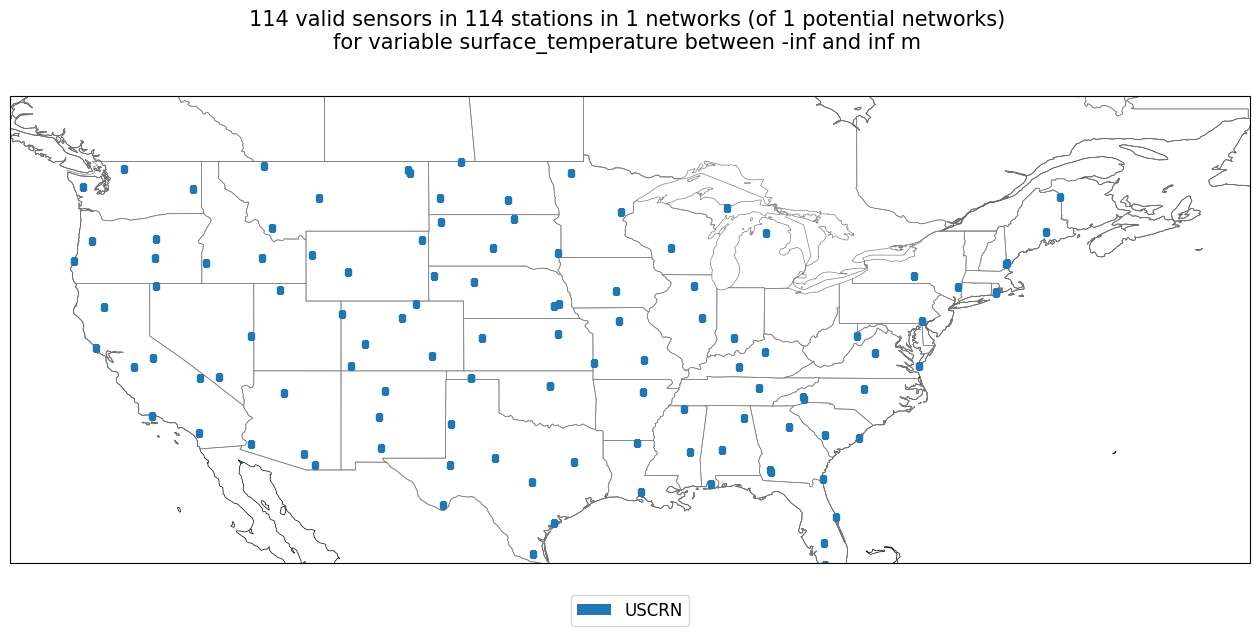

In [7]:
# Bonus: ismn has some nice compatibility with the cartopy package for plotting

# plot available station on a map
fig, ax = plt.subplots(
    1, 1, figsize=(16, 10), subplot_kw={"projection": ccrs.PlateCarree()}
)
uscrn_data.plot_station_locations(
    "surface_temperature", ax=ax, markersize=5, text_scalefactor=3
)
ax.set_extent([-128, -57, 26, 47])  # US aproximate coordinate range
plt.show()

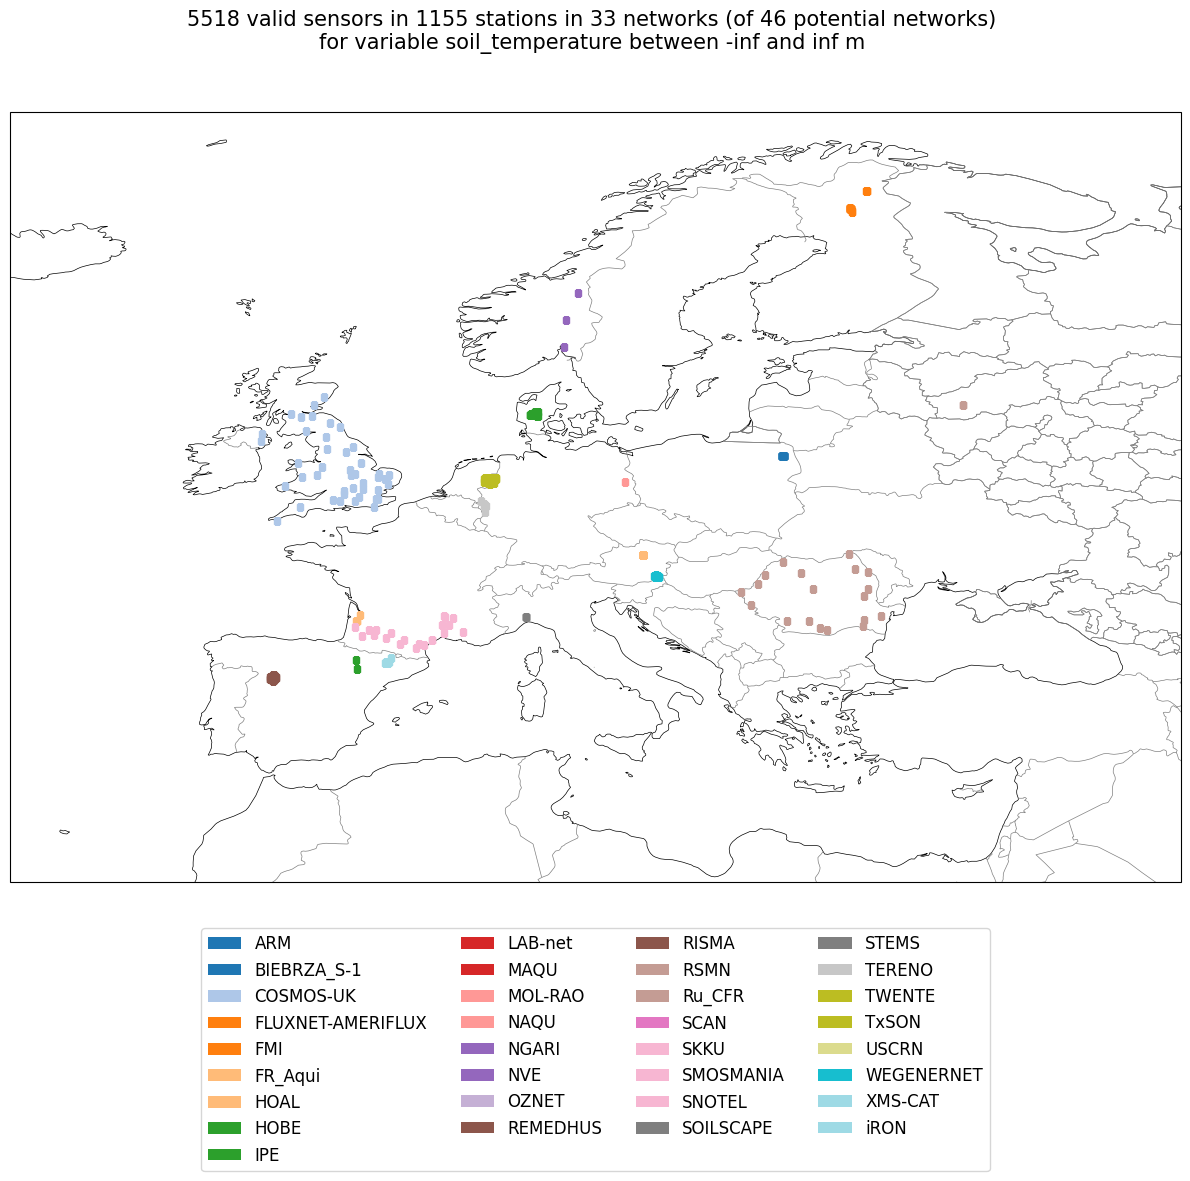

In [24]:
# Bonus: ismn has some nice compatibility with the cartopy package for plotting

# plot available station on a map
fig, ax = plt.subplots(
    1, 1, figsize=(16, 10), subplot_kw={"projection": ccrs.PlateCarree()}
)

ismn_data.plot_station_locations(
    "soil_temperature", ax=ax, markersize=5, text_scalefactor=3
)
ax.set_extent([-20, 45, 30, 70])  # EU aproximate coordinate range
plt.show()

In [12]:
# To recover the data from the sensors we iterate using the collectioniter_sensors()
valid_sensors = []
for network, station, sensor in uscrn_data.collection.iter_sensors(depth=[0, 0]):
    if (
        np.min(sensor.data["surface_temperature"]) > -100
    ):  # Some data will have badly recovered LST
        valid_sensors.append((network, station, sensor))

len(valid_sensors)

""" 
Unfortunatly, the ISMN package is old and not updated too often, so using some pandas versions will cause this FutureWarning to appear:

[...] venv\lib\site-packages\ismn\filehandlers.py:659: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated.
Combine the desired columns with pd.to_datetime after parsing instead.
return pd.read_csv(
  
"""

c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated an

" \nUnfortunatly, the ISMN package is old and not updated too often, so using some pandas versions will cause this FutureWarning to appear:\n\n[...] venv\\lib\\site-packages\\ismn\x0cilehandlers.py:659: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated.\nCombine the desired columns with pd.to_datetime after parsing instead.\nreturn pd.read_csv(\n  \n"

In [13]:
# Extract ascending and descendig passes (6pm and 6am)

# Use the first sensor on the list as an example:
network, station, sensor = valid_sensors[0]

# This method returns a dataset for each sensor
timeseries = uscrn_data[network.name][station.name][sensor.name].data

# Filter by datetime index
ascending_ts = timeseries[timeseries.index.hour == 18]
descending_ts = timeseries[timeseries.index.hour == 6]

c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  readf = lambda f: pd.read_csv(


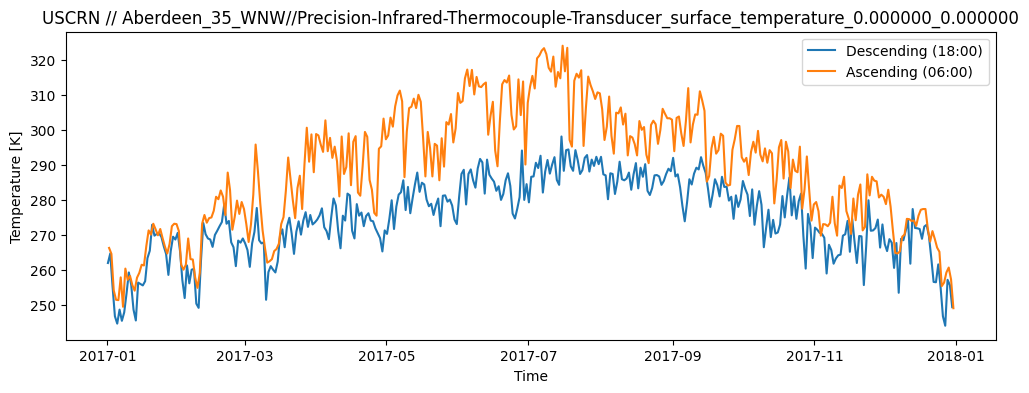

In [14]:
# Visualise 6pm-6am data from a station
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(descending_ts["surface_temperature"] + 273.15, label="Descending (18:00)")
ax.plot(ascending_ts["surface_temperature"] + 273.15, label="Ascending (06:00)")
ax.set_ylabel("Temperature [K]")
ax.set_xlabel("Time")
ax.legend()

ax.set_title(network.name + " // " + station.name + "//" + sensor.name)

plt.show()

In [15]:
# Save all instruments in the selected network:

instruments = {}
for network, station, sensor in uscrn_data.collection.iter_sensors(depth=[0, 0]):
    if sensor.instrument in instruments.keys():
        instruments[sensor.instrument] += 1
    else:
        instruments[sensor.instrument] = 1

print(instruments)

{'Precision-Infrared-Thermocouple-Transducer': 114}


In [16]:
count = 0
instruments = {}
for s in ismn_data.stations_that_measure("soil_temperature"):
    count += 1
    if sensor.instrument in instruments.keys():
        instruments[sensor.instrument] += 1
    else:
        instruments[sensor.instrument] = 1

print(count)
print(instruments)

1155
{'Precision-Infrared-Thermocouple-Transducer': 1155}


In [21]:
instruments = {}

for network, station, sensor in ismn_data.collection.iter_sensors():
    if sensor.instrument in instruments.keys():
        instruments[sensor.instrument] += 1
    else:
        instruments[sensor.instrument] = 1

for name, count in instruments.items():
    print(name, "-", count)

CS616-1 - 3
CS616-2 - 3
CS616 - 85
STP-1-A - 5
STP-1-B - 5
STP-1-C - 5
SMP1-A - 5
SMP1-B - 5
SMP1-C - 5
Hydraprobe-II-Sdi-12-W - 116
Hydraprobe-II-Sdi-12-S - 114
Hydraprobe-II-Sdi-12-E - 116
GS-3 - 144
Cosmic-ray-Probe - 108
TDT-B - 187
TDT-A - 188
STP01 - 215
TDT-C - 2
TDT-D - 2
Thermocouple-type-T - 25
CS655 - 128
ThetaProbe-ML3 - 29
ThetaProbe-ML2X - 124
5TE - 106
5TE-B - 4
5TE-A - 10
CS655-B - 8
CS655-A - 20
ThetaProbe-ML2X-A - 2
ThetaProbe-ML2X-B - 5
QMT103-C - 1
QMT103-B - 1
Flower-Power - 143
SPADE-Time-Domain-Transmissivity-A - 126
SPADE-Time-Domain-Transmissivity - 133
SPADE-Time-Domain-Transmissivity-B - 30
Decagon-5TE-A - 88
Decagon-5TE - 68
Decagon-5TE-B - 84
Decagon-5TE-C - 16
T107 - 17
CS650 - 4
Buriable-Waveguide - 101
107 - 1
109 - 1
ECH20-EC-TM - 102
TRIME-EZ - 5
PT-100 - 96
5TM - 313
Delta-T-PR2-daily-averages - 12
UMS-Th3-s-daily-averages - 6
Delta-T-PR1-daily-averages - 1
temperature-vertical-rod-daily-averages - 1
Pt100-sensor-daily-averages - 10
Decagon-5-TM-daily

(None, <GeoAxes: >, (1, 114, 114))

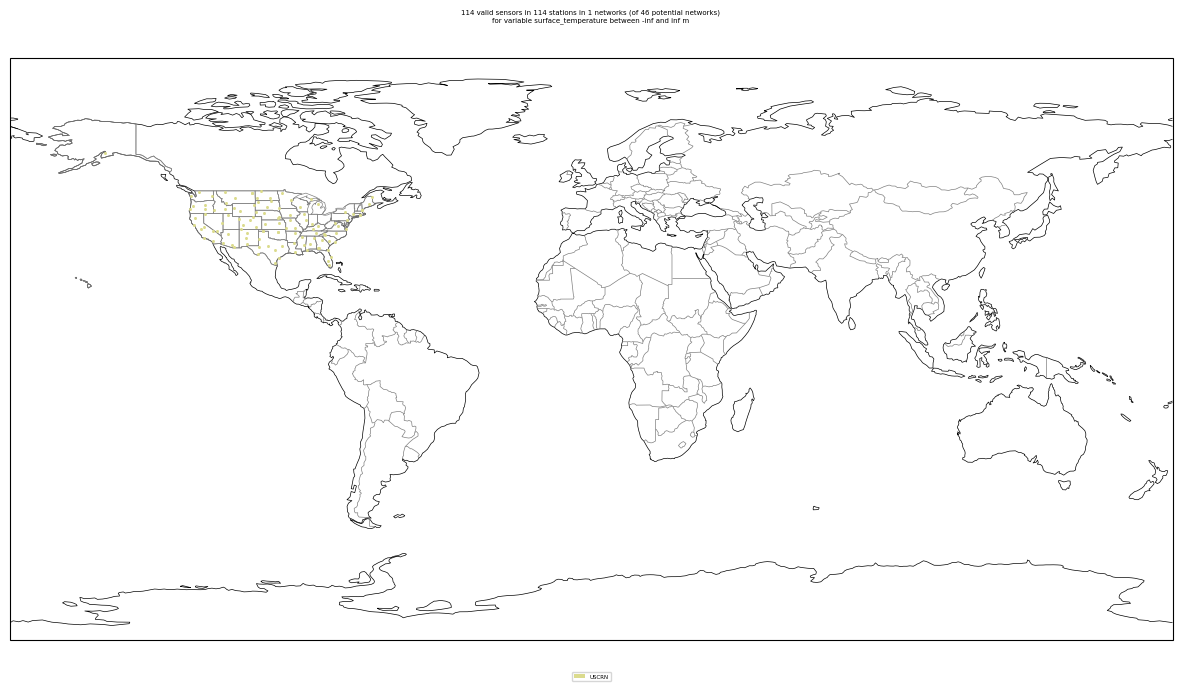

In [25]:
fig, ax = plt.subplots(
    1, 1, figsize=(15, 15), subplot_kw={"projection": ccrs.PlateCarree()}
)

ismn_data.plot_station_locations(variable="surface_temperature", ax=ax)

(None, <GeoAxes: >, (33, 1155, 5518))

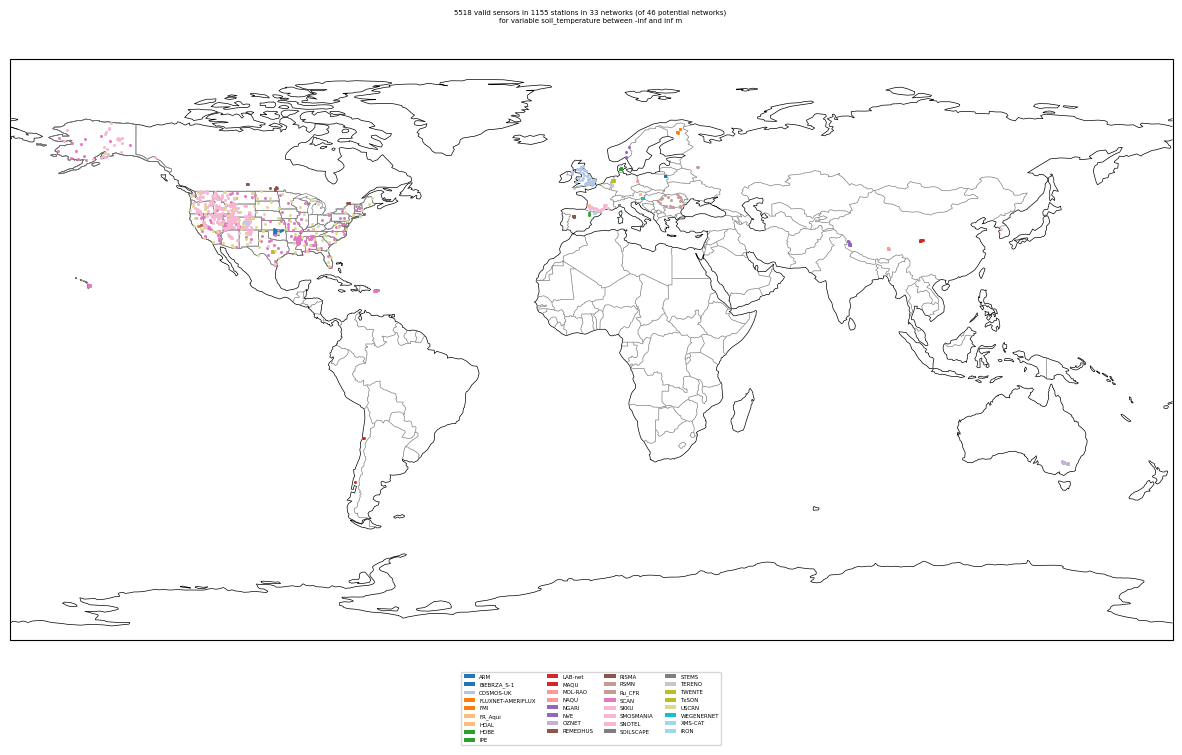

In [26]:
fig, ax = plt.subplots(
    1, 1, figsize=(15, 15), subplot_kw={"projection": ccrs.PlateCarree()}
)

ismn_data.plot_station_locations(variable="soil_temperature", ax=ax)

In [22]:
# Stations with soil temperature:

ids = ismn_data.get_dataset_ids(variable=["surface_temperature", "soil_temperature"])

st_data = ismn_data.subset_from_ids(ids)

Found existing ismn metadata in ..\data\raw\python_metadata\Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.csv.


In [23]:
sensor_count = {}
total = 0
for __, __, sensor in st_data.collection.iter_sensors():

    if sensor.instrument in sensor_count.keys():
        sensor_count[sensor.instrument] += 1

    else:
        sensor_count[sensor.instrument] = 1
    total += 1
print(total)

2094


In [24]:
sensor_count

{'STP-1-A': 5,
 'STP-1-B': 5,
 'STP-1-C': 5,
 'Hydraprobe-II-Sdi-12-W': 28,
 'Hydraprobe-II-Sdi-12-S': 28,
 'Hydraprobe-II-Sdi-12-E': 28,
 'GS-3': 36,
 'TDT-B': 55,
 'TDT-A': 56,
 'STP01': 129,
 'TDT-C': 1,
 'TDT-D': 1,
 'Thermocouple-type-T': 15,
 '5TE': 34,
 '5TE-B': 2,
 '5TE-A': 2,
 'CS655-B': 4,
 'CS655-A': 4,
 'QMT103-C': 1,
 'QMT103-B': 1,
 'ThetaProbe-ML2X': 6,
 'ThetaProbe-ML2X-B': 1,
 'SPADE-Time-Domain-Transmissivity-A': 63,
 'SPADE-Time-Domain-Transmissivity-B': 15,
 'Decagon-5TE-A': 26,
 'Decagon-5TE-B': 24,
 'Decagon-5TE-C': 8,
 'CS650': 2,
 '107': 1,
 '109': 1,
 'ECH20-EC-TM': 22,
 'PT-100': 44,
 '5TM': 73,
 'UMS-Th3-s-daily-averages': 2,
 'Pt100-sensor-daily-averages': 1,
 'Stevens-Hydra-Probe': 36,
 'Hydraprobe-II-Sdi-12-A': 51,
 'Hydraprobe-II-Sdi-12-B': 50,
 'Hydraprobe-II-Sdi-12-C': 50,
 'Hydraprobe-II-A': 2,
 'Hydraprobe-II-B': 2,
 'Hydraprobe-II-C': 2,
 'Hydraprobe-Analog-(2.5-Volt)': 455,
 'Hydraprobe-Digital-Sdi-12-(2.5-Volt)': 90,
 'Hydraprobe-Digital-Sdi-12-The

(None, <GeoAxes: >, (46, 1647, 5647))

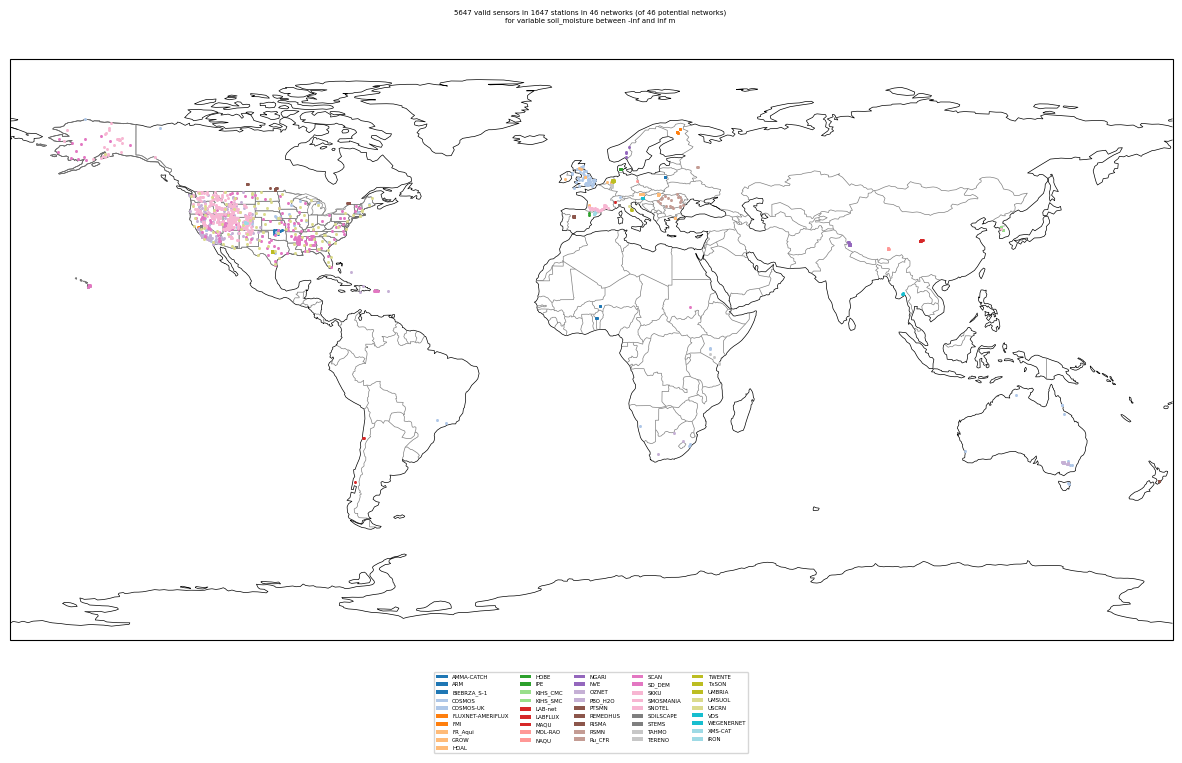

In [25]:
fig, ax = plt.subplots(
    1, 1, figsize=(15, 15), subplot_kw={"projection": ccrs.PlateCarree()}
)
ismn_data.plot_station_locations(variable="soil_moisture", ax=ax)

In [154]:
ids = ismn_data.get_dataset_ids(
    variable=ismn_data.get_variables(), filter_meta_dict={"network": "COSMOS"}
)

uk_data = ismn_data.subset_from_ids(ids)

Found existing ismn metadata in ..\data\raw\python_metadata\Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.csv.


In [155]:
uk_data

ismn.base.IsmnRoot Zip at ..\data\raw\Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.zip
with Networks[Stations]:
------------------------
  COSMOS: ['Bondville', 'Daniel_Forest', 'GLEES', 'Howland', 'KLEE', 'Rietholzbach', 'Tenderfoot_Creek', 'Trail_Valley_Main_Met']

In [156]:
cosmos_sensors = []
for network, station, sensor in uk_data.collection.iter_sensors(depth=[0, 100]):
    cosmos_sensors.append((network, station, sensor))
len(cosmos_sensors)

8

In [157]:
network, station, sensor = cosmos_sensors[0]

# This method returns a dataset for each sensor
timeseries = uk_data[network.name][station.name][sensor.name].data

# Filter by datetime index
ascending_ts = timeseries[timeseries.index.hour == 18]
descending_ts = timeseries[timeseries.index.hour == 6]

print(ascending_ts.columns)

Index(['soil_moisture', 'soil_moisture_flag', 'soil_moisture_orig_flag'], dtype='object')


c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  readf = lambda f: pd.read_csv(


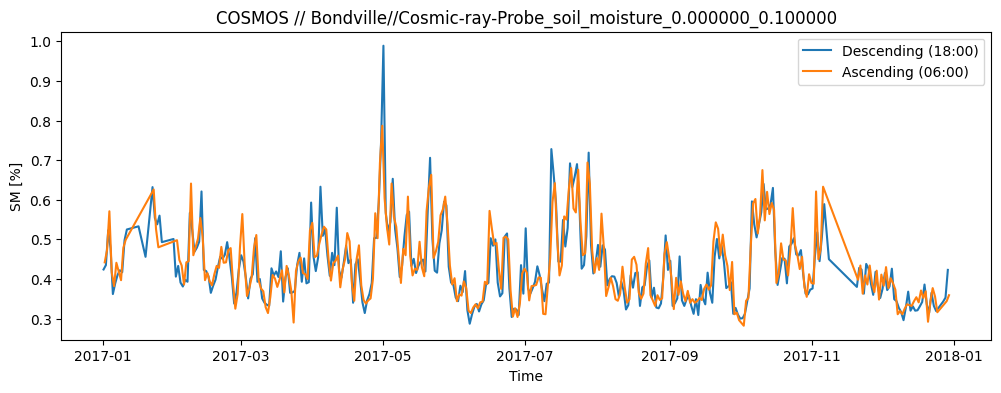

In [161]:
# Visualise 6pm-6am data from a station
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(descending_ts["soil_moisture"], label="Descending (18:00)")
ax.plot(ascending_ts["soil_moisture"], label="Ascending (06:00)")
ax.set_ylabel("SM [%]")
ax.set_xlabel("Time")
ax.legend()

ax.set_title(network.name + " // " + station.name + "//" + sensor.name)

plt.show()

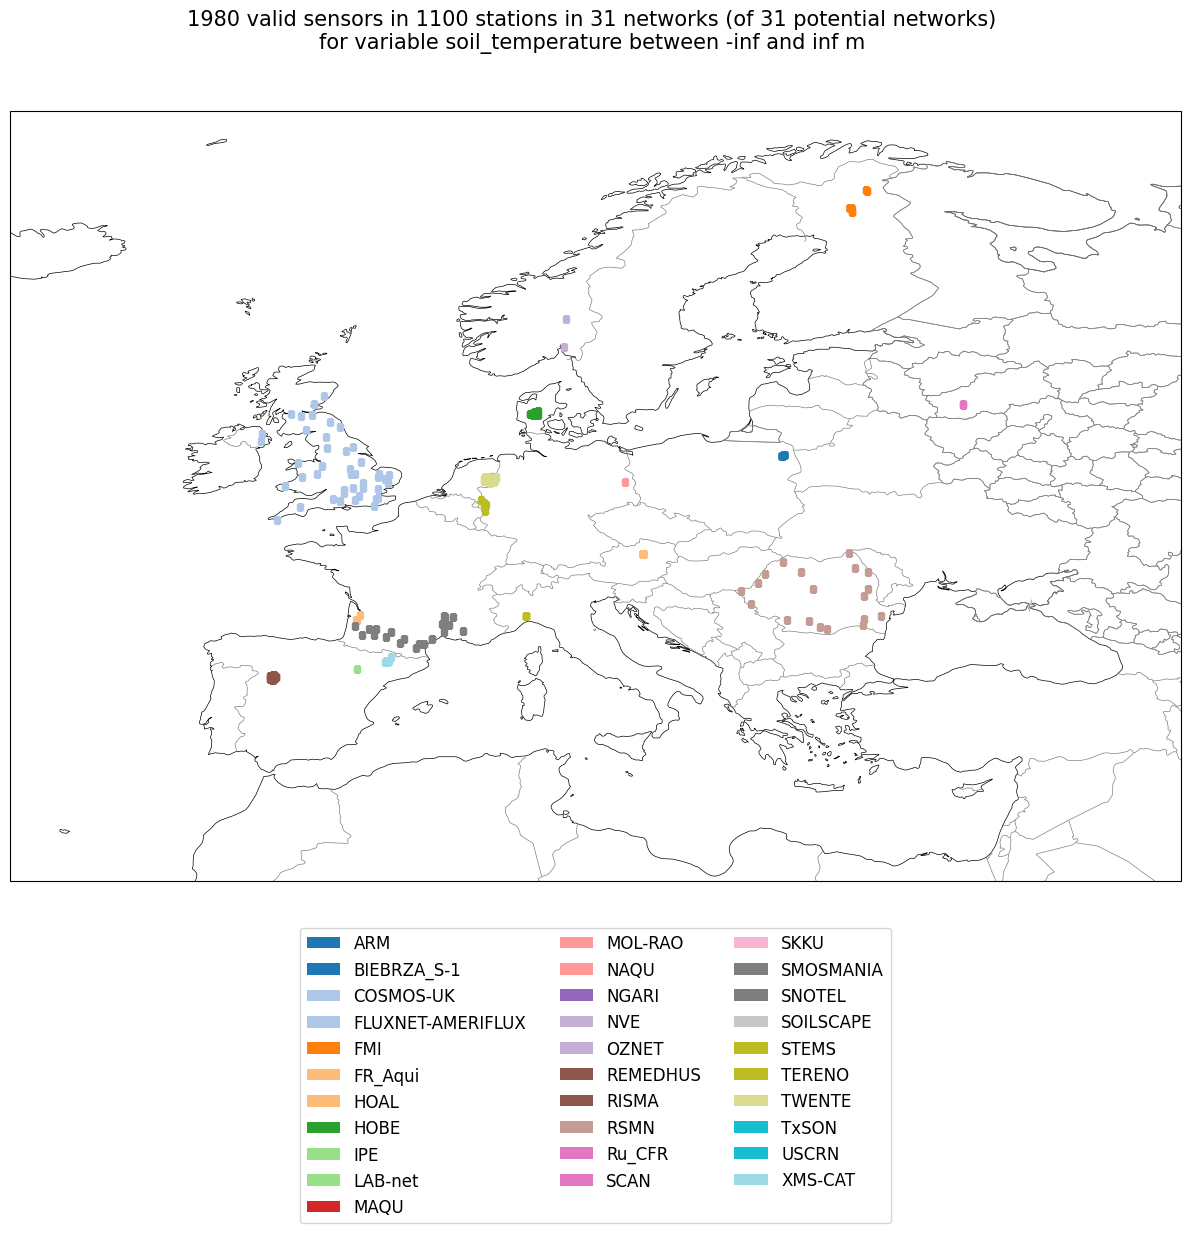

In [132]:
# plot available station on a map
fig, ax = plt.subplots(
    1, 1, figsize=(16, 10), subplot_kw={"projection": ccrs.PlateCarree()}
)

st_data.plot_station_locations(
    "soil_temperature", ax=ax, markersize=5, text_scalefactor=3
)
ax.set_extent([-20, 45, 30, 70])  # EU aproximate coordinate range
plt.show()

In [134]:
# Number of stations that measure temperature all across the globe
st_stations = [
    station
    for station in st_data.stations_that_measure(
        ["soil_temperature", "surface_temperature"]
    )
]
len(st_stations)

1101

## Interesting networks in EU
COSMOS-UK  (UK)  
RSMN   (ROMANIA)  
SMOSMANIA  (Southern France)  

We could validate with all of them but those three are the ones that better cover their respective territory (outside the US)


# RSMN network
Stations, sensors and depths

All 19 sensors are 5TM and measure soil temperature between 0 and 5cm of depth

About 5TM sensors
https://s.campbellsci.com/documents/ca/product-brochures/5tm_br.pdf


In [108]:
ids = ismn_data.get_dataset_ids(
    variable=["soil_temperature", "surface_temperature"],
    filter_meta_dict={"network": "RSMN"},
)
romania_data = ismn_data.subset_from_ids(ids)

Found existing ismn metadata in ..\data\raw\python_metadata\Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.csv.


In [110]:
# Count the instruments in the network:
instruments = {}

for network, station, sensor in romania_data.collection.iter_sensors():
    if sensor.instrument in instruments.keys():
        instruments[sensor.instrument] += 1
    else:
        instruments[sensor.instrument] = 1

for name, count in instruments.items():
    print(name, "-", count)

5TM - 19


In [112]:
# List all the sensors:
romania_sensors = []
for network, station, sensor in romania_data.collection.iter_sensors(depth=[0, 100]):
    romania_sensors.append((network, station, sensor))
len(romania_sensors)

19

In [121]:
[s for _, _, s in romania_sensors]

[5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000,
 5TM_soil_temperature_0.000000_0.050000]

In [130]:
network, station, sensor = romania_sensors[4]

# This method returns a dataset for each sensor
timeseries = romania_data[network.name][station.name][sensor.name].data

# Filter by datetime index
ascending_ts = timeseries[timeseries.index.hour == 18]
descending_ts = timeseries[timeseries.index.hour == 6]
print(ascending_ts.columns)

Index(['soil_temperature', 'soil_temperature_flag',
       'soil_temperature_orig_flag'],
      dtype='object')


c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  readf = lambda f: pd.read_csv(


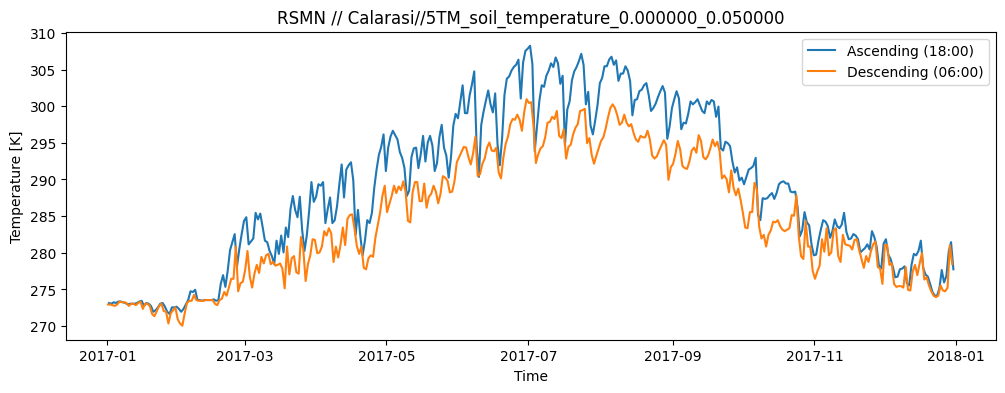

In [131]:
# Visualise 6pm-6am data from a station
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(ascending_ts["soil_temperature"] + 273.15, label="Ascending (18:00)")
ax.plot(descending_ts["soil_temperature"] + 273.15, label="Descending (06:00)")
ax.set_ylabel("Temperature [K]")
ax.set_xlabel("Time")
ax.legend()

ax.set_title(network.name + " // " + station.name + "//" + sensor.name)

plt.show()

## COSMOS-UK network

113 TDT sensors: (Time Domain Transmissometry)  
*no info on what models, but up to 4 types (A,B,C,D) or maybe is just a counting tag for each station.


129 STP01 sensors: https://www.hukseflux.com/uploads/product-documents/STP01_v1625.pdf
(Termocuple type T)

*depths vary , but all are exactly 2, 5 or 10 cm below ground.

In [ ]:
ids = st_data.get_dataset_ids(
    variable=["soil_temperature", "surface_temperature"],
    filter_meta_dict={"network": "COSMOS-UK"},
)
uk_data = st_data.subset_from_ids(ids)

In [129]:
instruments = {}

for network, station, sensor in uk_data.collection.iter_sensors():
    if sensor.instrument in instruments.keys():
        instruments[sensor.instrument] += 1
    else:
        instruments[sensor.instrument] = 1

for name, count in instruments.items():
    print(name, "-", count)

TDT-B - 55
TDT-A - 56
STP01 - 129
TDT-C - 1
TDT-D - 1


In [140]:
# Varing depths:
cosmos_sensors = [
    (network, station, sensor)
    for network, station, sensor in uk_data.collection.iter_sensors()
]

[s for _, _, s in cosmos_sensors]

[TDT-B_soil_temperature_0.100000_0.100000,
 TDT-A_soil_temperature_0.100000_0.100000,
 STP01_soil_temperature_0.020000_0.020000,
 STP01_soil_temperature_0.100000_0.100000,
 STP01_soil_temperature_0.050000_0.050000,
 TDT-A_soil_temperature_0.100000_0.100000,
 STP01_soil_temperature_0.020000_0.020000,
 STP01_soil_temperature_0.100000_0.100000,
 STP01_soil_temperature_0.050000_0.050000,
 TDT-B_soil_temperature_0.100000_0.100000,
 TDT-A_soil_temperature_0.100000_0.100000,
 STP01_soil_temperature_0.020000_0.020000,
 STP01_soil_temperature_0.100000_0.100000,
 STP01_soil_temperature_0.050000_0.050000,
 TDT-B_soil_temperature_0.100000_0.100000,
 TDT-A_soil_temperature_0.100000_0.100000,
 STP01_soil_temperature_0.020000_0.020000,
 STP01_soil_temperature_0.100000_0.100000,
 STP01_soil_temperature_0.050000_0.050000,
 TDT-B_soil_temperature_0.100000_0.100000,
 TDT-A_soil_temperature_0.100000_0.100000,
 STP01_soil_temperature_0.020000_0.020000,
 STP01_soil_temperature_0.100000_0.100000,
 STP01_soil

In [135]:
network, station, sensor = cosmos_sensors[4]

# This method returns a dataset for each sensor
timeseries = uk_data[network.name][station.name][sensor.name].data

# Filter by datetime index
ascending_ts = timeseries[timeseries.index.hour == 18]
descending_ts = timeseries[timeseries.index.hour == 6]
print(ascending_ts.columns)

Index(['soil_temperature', 'soil_temperature_flag',
       'soil_temperature_orig_flag'],
      dtype='object')


c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  readf = lambda f: pd.read_csv(


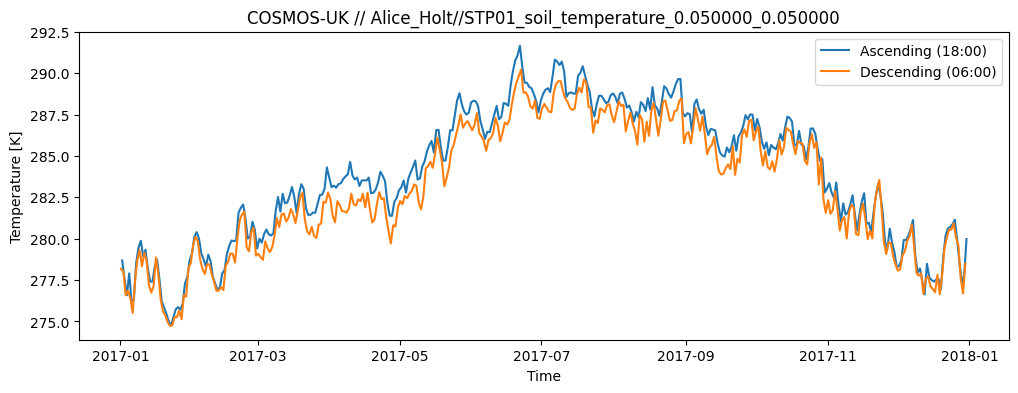

In [136]:
# Visualise 6pm-6am data from a station
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(ascending_ts["soil_temperature"] + 273.15, label="Ascending (18:00)")
ax.plot(descending_ts["soil_temperature"] + 273.15, label="Descending (06:00)")
ax.set_ylabel("Temperature [K]")
ax.set_xlabel("Time")
ax.legend()

ax.set_title(network.name + " // " + station.name + "//" + sensor.name)

plt.show()

# SMOSMANIA 
42 PT-100 sensors: (Resistant type detector), no specifics on the exact model. 

*Either exactly 5 or 10 cm of depth

In [137]:
ids = st_data.get_dataset_ids(
    variable=["soil_temperature", "surface_temperature"],
    filter_meta_dict={"network": "SMOSMANIA"},
)
fr_data = st_data.subset_from_ids(ids)

Found existing ismn metadata in ..\data\raw\python_metadata\Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.csv.


In [138]:
instruments = {}

for network, station, sensor in fr_data.collection.iter_sensors():
    if sensor.instrument in instruments.keys():
        instruments[sensor.instrument] += 1
    else:
        instruments[sensor.instrument] = 1

for name, count in instruments.items():
    print(name, "-", count)

PT-100 - 42


In [141]:
# Depths:
fr_sensors = [
    (network, station, sensor)
    for network, station, sensor in fr_data.collection.iter_sensors()
]

[s for _, _, s in fr_sensors]

[PT-100_soil_temperature_0.050000_0.050000,
 PT-100_soil_temperature_0.100000_0.100000,
 PT-100_soil_temperature_0.050000_0.050000,
 PT-100_soil_temperature_0.100000_0.100000,
 PT-100_soil_temperature_0.050000_0.050000,
 PT-100_soil_temperature_0.100000_0.100000,
 PT-100_soil_temperature_0.050000_0.050000,
 PT-100_soil_temperature_0.100000_0.100000,
 PT-100_soil_temperature_0.050000_0.050000,
 PT-100_soil_temperature_0.100000_0.100000,
 PT-100_soil_temperature_0.050000_0.050000,
 PT-100_soil_temperature_0.100000_0.100000,
 PT-100_soil_temperature_0.050000_0.050000,
 PT-100_soil_temperature_0.100000_0.100000,
 PT-100_soil_temperature_0.050000_0.050000,
 PT-100_soil_temperature_0.100000_0.100000,
 PT-100_soil_temperature_0.050000_0.050000,
 PT-100_soil_temperature_0.100000_0.100000,
 PT-100_soil_temperature_0.050000_0.050000,
 PT-100_soil_temperature_0.100000_0.100000,
 PT-100_soil_temperature_0.050000_0.050000,
 PT-100_soil_temperature_0.100000_0.100000,
 PT-100_soil_temperature_0.05000

In [146]:
network, station, sensor = fr_sensors[0]

# This method returns a dataset for each sensor
timeseries = fr_data[network.name][station.name][sensor.name].data

# Filter by datetime index
ascending_ts = timeseries[timeseries.index.hour == 18]
descending_ts = timeseries[timeseries.index.hour == 6]
print(ascending_ts.columns)

Index(['soil_temperature', 'soil_temperature_flag',
       'soil_temperature_orig_flag'],
      dtype='object')


c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  readf = lambda f: pd.read_csv(


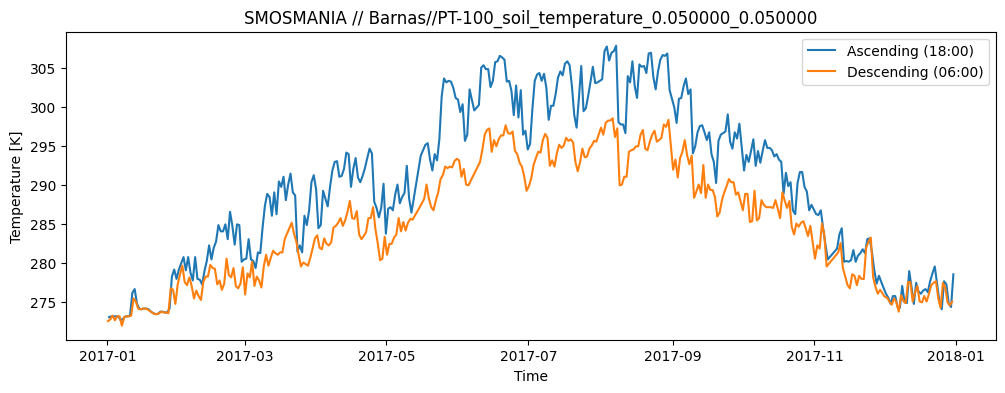

In [147]:
# Visualise 6pm-6am data from a station
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(ascending_ts["soil_temperature"] + 273.15, label="Ascending (18:00)")
ax.plot(descending_ts["soil_temperature"] + 273.15, label="Descending (06:00)")
ax.set_ylabel("Temperature [K]")
ax.set_xlabel("Time")
ax.legend()

ax.set_title(network.name + " // " + station.name + "//" + sensor.name)

plt.show()